In [1]:
import os
from os import path
import glob
import warnings
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
from pyia import GaiaData
from sfd import reddening
from astroquery.gaia import Gaia

login_file = path.expanduser('~/.gaia/archive.login')
if path.exists(login_file):
    with open(login_file) as f:
        username = f.readline()
        password = f.readline()
    print('Logging in with user: {0}'.format(username))
    Gaia.login(user=username, password=password)
    
    
# Load nominal isochrone
iso = Table.read('/Users/adrian/data/Isochrones/MIST/FeH_-2.0_iso.fits')
iso = iso[iso['log10_isochrone_age_yr'] == 10.1]
iso = iso[(iso['phase'] > 0) & (iso['phase'] <= 4)]

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Logging in with user: apricewh



In [2]:
data_path = '../data/jhelum-polygon/'
os.makedirs(data_path, exist_ok=True)

In [3]:
gaia_cols = ['source_id', 
             'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_parallax_corr', 'ra_pmra_corr', 
             'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 
             'parallax_pmdec_corr', 'pmra_pmdec_corr', 'visibility_periods_used', 
             'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 
             'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error', 
             'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error', 
             'phot_bp_rp_excess_factor', 'astrometric_chi2_al', 'astrometric_n_good_obs_al']
gaia_cols = ['gaia.'+x for x in gaia_cols]

In [4]:
tmass_cols = ['ph_qual', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m', 'ks_msigcom']
tmass_cols = ['tmass.'+x for x in tmass_cols]

In [5]:
q_base ='''SELECT {0}
FROM gaiadr2.gaia_source as gaia
    LEFT JOIN gaiadr1.tmass_best_neighbour AS xmatch
        ON gaia.source_id = xmatch.source_id
    LEFT JOIN gaiadr1.tmass_original_valid AS tmass
        ON tmass.tmass_oid = xmatch.tmass_oid
WHERE gaia.parallax < 0.75 AND
      CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
               POLYGON('ICRS', 
                       {1[0].ra.degree}, {1[0].dec.degree}, 
                       {1[1].ra.degree}, {1[1].dec.degree}, 
                       {1[2].ra.degree}, {1[2].dec.degree}, 
                       {1[3].ra.degree}, {1[3].dec.degree})) = 1
'''

In [6]:
# From Shipp et al. 2018
c1 = coord.SkyCoord(ra=-38.8*u.deg, dec=-45.1*u.deg)
c2 = coord.SkyCoord(ra=4.7*u.deg, dec=-51.7*u.deg)
jhelum_frame = gc.GreatCircleICRSFrame.from_endpoints(c1, c2)

In [7]:
queries = []
jobs = []
for l in np.arange(-30, 30, 10):
    print(l)
    
    fn = path.join(data_path, 'jhelum-{0:.0f}-result.fits.gz'.format(l))
    if path.exists(fn):
        print('{0} exists...skipping'.format(fn))
        continue

    corners = jhelum_frame.realize_frame(coord.UnitSphericalRepresentation(
        lon=[l, l, l+10, l+10]*u.deg,
        lat=[-8, 8, 8, -8]*u.deg))
    corners_icrs = corners.transform_to(coord.ICRS)
    q = q_base.format(', '.join(gaia_cols + tmass_cols), corners_icrs)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        job = Gaia.launch_job_async(q, name='Jhelum-{0}'.format(l), 
                                    background=True)
    jobs.append(job)

-30
../data/jhelum-polygon/jhelum--30-result.fits.gz exists...skipping
-20
../data/jhelum-polygon/jhelum--20-result.fits.gz exists...skipping
-10
../data/jhelum-polygon/jhelum--10-result.fits.gz exists...skipping
0
../data/jhelum-polygon/jhelum-0-result.fits.gz exists...skipping
10
../data/jhelum-polygon/jhelum-10-result.fits.gz exists...skipping
20
../data/jhelum-polygon/jhelum-20-result.fits.gz exists...skipping


Download files from archive...

### combine tables

In [8]:
from numpy.lib.recfunctions import stack_arrays

In [9]:
all_filename = '../data/gaia-jhelum.fits'
if not path.exists(all_filename):
    arrs = []
    for filename in glob.glob('../data/jhelum-polygon/*.fits.gz'):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    t = Table(arr)
    t.write(all_filename)

In [10]:
g = GaiaData(all_filename)

In [11]:
d = coord.Distance(distmod=15.6)
icrs_c = g.get_skycoord(distance=d, radial_velocity=0*u.km/u.s)
c = icrs_c.transform_to(jhelum_frame)
# c = gc.reflex_correct(c)

In [12]:
phi1 = c.phi1.wrap_at(180*u.deg).degree
phi2 = c.phi2.degree
pm1 = c.pm_phi1_cosphi2.to_value(u.mas/u.yr)
pm2 = c.pm_phi2.to_value(u.mas/u.yr)

In [13]:
mG = g.phot_g_mean_mag
mBPRP = g.phot_bp_mean_mag - g.phot_rp_mean_mag

mag_mask = ((mG < 20*u.mag) & 
            (g.phot_bp_mean_mag < 20*u.mag) &
            (g.phot_rp_mean_mag < 20*u.mag))
G_mask = mG < 18.*u.mag
G_mask.sum(), mag_mask.sum()

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(840537, 1804344)

In [14]:
jh_mask = (np.abs(phi1) < 14.) & (phi2 > -2.) & (phi2 < 1.5)
bg_mask = ((np.abs(phi1) < 14.) & (((phi2 > 2) & (phi2 < 4)) | 
                                   ((phi2 < -3) & (phi2 > -4.5))))
jh_mask.sum(), bg_mask.sum()

(253470, 248271)

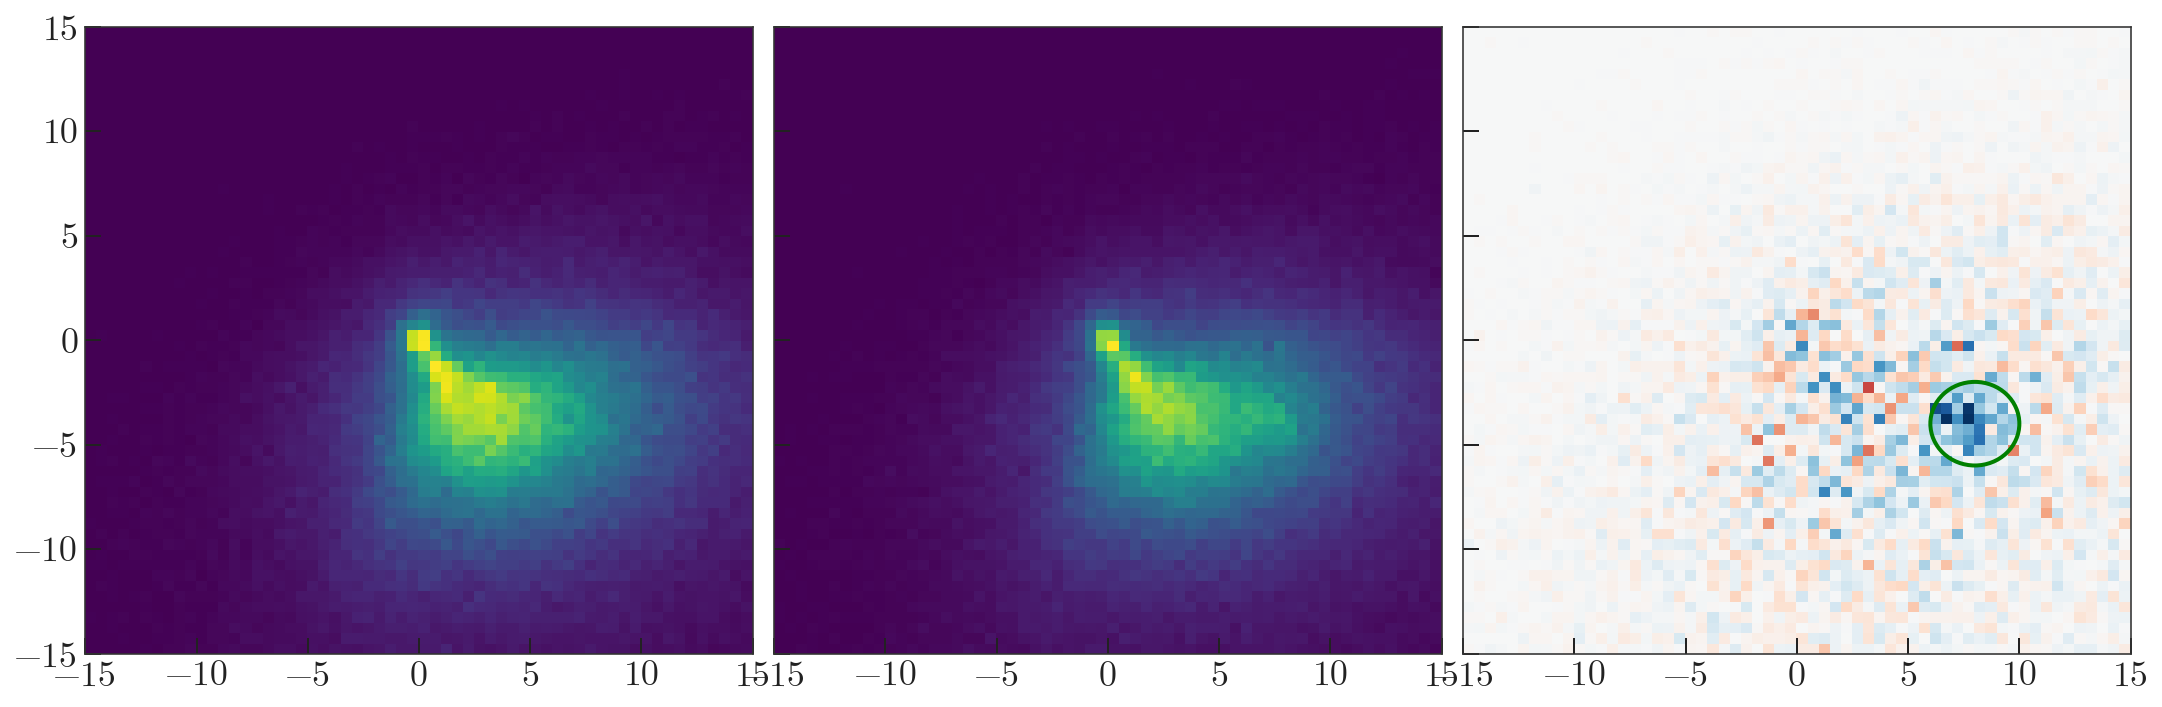

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True)

Hs = []
for i, mask in enumerate([bg_mask, jh_mask]):
    H, xe, ye = np.histogram2d(pm1[mask], pm2[mask],
                               bins=np.arange(-15, 15+1e-3, 0.5))
    axes[i].pcolormesh(xe, ye, H.T)
    Hs.append(H)
    
axes[2].pcolormesh(xe, ye, (Hs[1] - Hs[0]).T, 
                   cmap='RdBu', vmin=-100, vmax=100)

# pmxy0 = [6., -1.]
pmxy0 = [8., -4.]
pmr = 2.
circ = mpl.patches.Circle(pmxy0, pmr,
                          facecolor='none', linewidth=2, 
                          edgecolor='green')
axes[2].add_patch(circ)

ax = axes[0]
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

fig.tight_layout()

Hack, just to look at CMD:

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


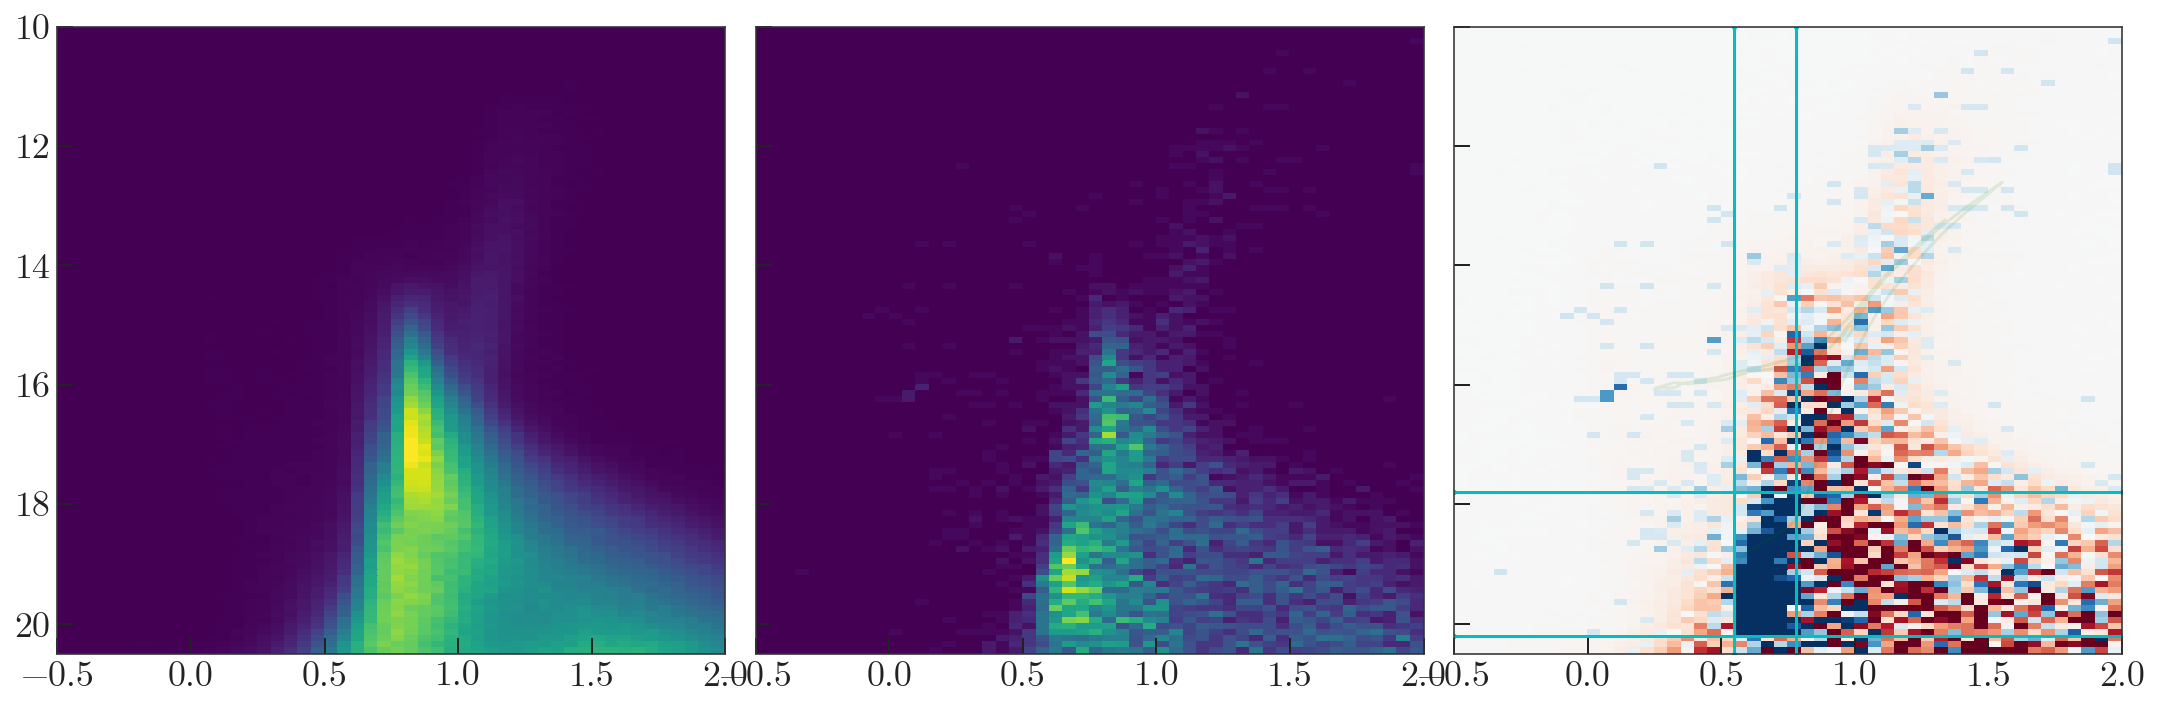

In [16]:
pm_mask = np.sqrt((pm1 - pmxy0[0])**2 + (pm2 - pmxy0[1])**2) < pmr

fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True)

bins = (np.arange(-0.5, 2.+1e-3, 0.05),
        np.arange(10, 20.5+1e-3, 0.1))
H1, xe, ye = np.histogram2d(mBPRP[~(jh_mask & pm_mask)], mG[~(jh_mask & pm_mask)], 
                            bins=bins)
axes[0].pcolormesh(xe, ye, H1.T)

                            
H2, xe, ye = np.histogram2d(mBPRP[jh_mask & pm_mask], mG[jh_mask & pm_mask], 
                            bins=bins)
axes[1].pcolormesh(xe, ye, H2.T)
    
f = H1.sum() / H2.sum()
axes[2].pcolormesh(xe, ye, (f * H2 - H1).T, 
                   cmap='RdBu', vmin=-1e3, vmax=1e3)

axes[2].plot(iso['G_BP']-iso['G_RP'],
             iso['G']+d.distmod.value,
             marker='', alpha=0.1, color='green', zorder=1000)
    
axes[0].set_xlim(-0.5, 2.)
axes[0].set_ylim(20.5, 10)

axes[2].axhline(17.8, color='c')
axes[2].axhline(20.2, color='c')
axes[2].axvline(0.55, color='c')
axes[2].axvline(0.78, color='c')
cmd_box = ((mBPRP > 0.55*u.mag) & (mBPRP < 0.78*u.mag) & 
           (mG > 17.8*u.mag) & (mG < 20.2*u.mag))

fig.tight_layout()

quick look to see that stream is visible with rough PM mask + CMD box:

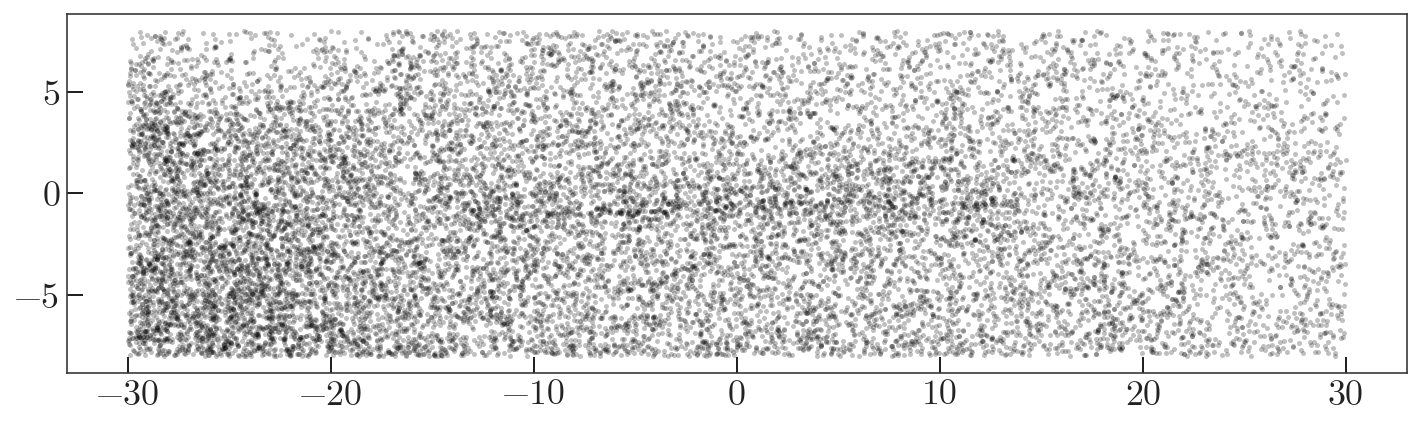

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(phi1[pm_mask & cmd_box], phi2[pm_mask & cmd_box], 
        marker='.', ls='none', alpha=0.25, color='k')

# ax.axhline(-2.5, color='tab:red')
# ax.axhline(1.5, color='tab:red')

ax.set_aspect('equal')

## proper motion membership

First, build background model, fit stream + background model to MSTO stars, infer cluster proper motion. Then go back and use the inferred proper motion to find RGB members

In [18]:
from xdgmm import XDGMM
from extreme_deconvolution.extreme_deconvolution import extreme_deconvolution as bovyXD
from astroML.plotting.tools import draw_ellipse
from astroML.utils import log_multivariate_gaussian
from scipy.optimize import minimize
from scipy.special import logsumexp
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

from gala.coordinates.greatcircle import reference_to_greatcircle

In [19]:
R = reference_to_greatcircle(coord.ICRS, jhelum_frame)

TODO: this notation and math comes from [this document](https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html) - this should be extracted and added to Gala or Astropy!

In [20]:
def get_uv_tan(c):
    l = c.spherical.lon
    b = c.spherical.lat
    
    p = np.array([-np.sin(l), np.cos(l), np.zeros(len(l))]).T
    q = np.array([-np.cos(l)*np.sin(b), -np.sin(l)*np.sin(b), np.cos(b)]).T
    
    return np.stack((p, q), axis=-1)

uv_icrs = get_uv_tan(icrs_c)
uv_gd1 = get_uv_tan(c)
G = np.einsum('nab,nac->nbc', uv_gd1, np.einsum('ji,nik->njk', R, uv_icrs))

In [21]:
mu = np.vstack((g.pmra.value, 
                g.pmdec.value)).T
V = g.get_cov()[:, 3:5, 3:5]

# transform
mu = np.einsum('njk,nk->nj', G, mu)
V = np.einsum('nba,nac->nbc', G, 
              np.einsum('nij,nki->njk', V, G))

In [22]:
assert np.allclose(np.sort(np.linalg.eigvals(V[0])), 
                   np.sort(np.linalg.eigvals(g[0].get_cov()[0, 3:5, 3:5])))

In [23]:
X_jh = mu[jh_mask & cmd_box]
X_bg = mu[bg_mask & cmd_box]

Cov_jh = V[jh_mask & cmd_box]
Cov_bg = V[bg_mask & cmd_box]

X_bg.shape, X_jh.shape

((22132, 2), (23386, 2))

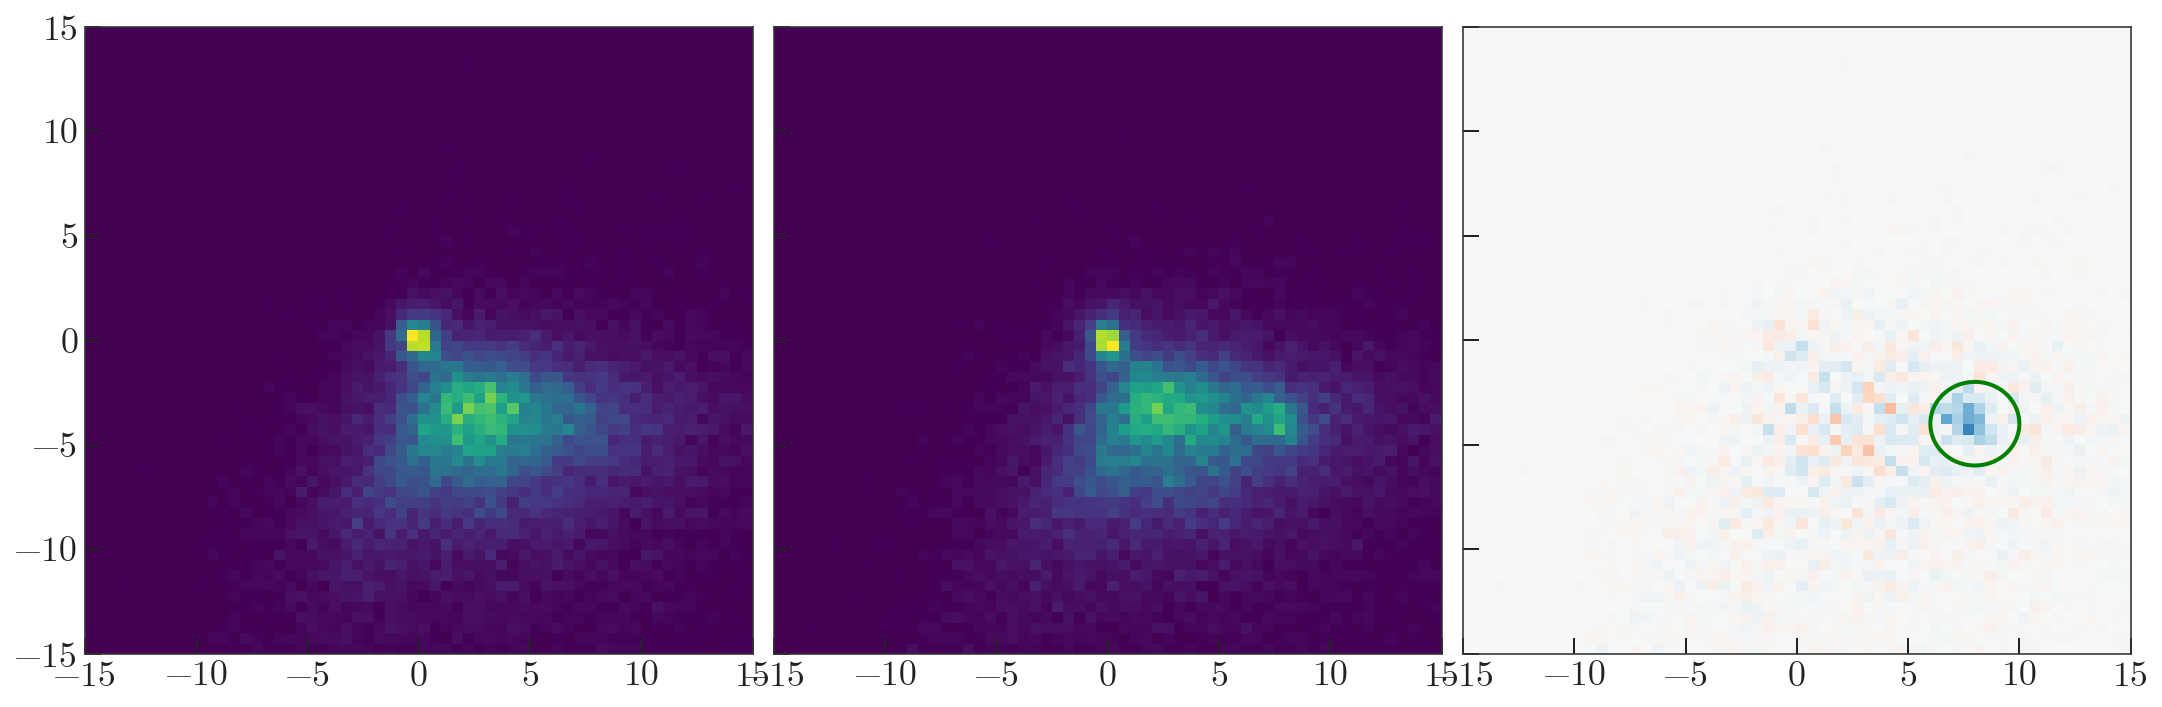

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True)

Hs = []
for i, X in enumerate([X_bg, X_jh]):
    H, xe, ye = np.histogram2d(X[:, 0], X[:, 1],
                               bins=np.arange(-15, 15+1e-3, 0.5))
    axes[i].pcolormesh(xe, ye, H.T)
    Hs.append(H)
    
axes[2].pcolormesh(xe, ye, (Hs[1] - Hs[0]).T, 
                   cmap='RdBu', vmin=-100, vmax=100)

circ = mpl.patches.Circle(pmxy0, pmr,
                          facecolor='none', linewidth=2, 
                          edgecolor='green')
axes[2].add_patch(circ)

ax = axes[0]
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

fig.tight_layout()

In [25]:
# xdgmm = XDGMM(method='Bovy')

# param_range = np.arange(1, 8+1, 1)

# # # Loop over component numbers, fitting XDGMM model and computing the BIC:
# bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X_bg[::8], Cov_bg[::8], 
#                                                  param_range)

In [26]:
%%time 

filename = 'gmm_bits.pickle'
if not path.exists(filename):
    optimal_n_comp = 5 # from above
    gmm = XDGMM(n_components=optimal_n_comp, 
                random_state=np.random.RandomState(123),
                method='Bovy', n_iter=1024)
    _ = gmm.fit(X_bg, Cov_bg)

    with open(filename, 'wb') as f:
        pickle.dump((gmm.mu, gmm.V, gmm.weights), f)

else:
    with open(filename, 'rb') as f:
        (_mu, _V, _weights) = pickle.load(f)
        
    gmm = XDGMM(mu=_mu, V=_V, weights=_weights)

CPU times: user 668 µs, sys: 1.1 ms, total: 1.76 ms
Wall time: 1.45 ms


(-20, 20)

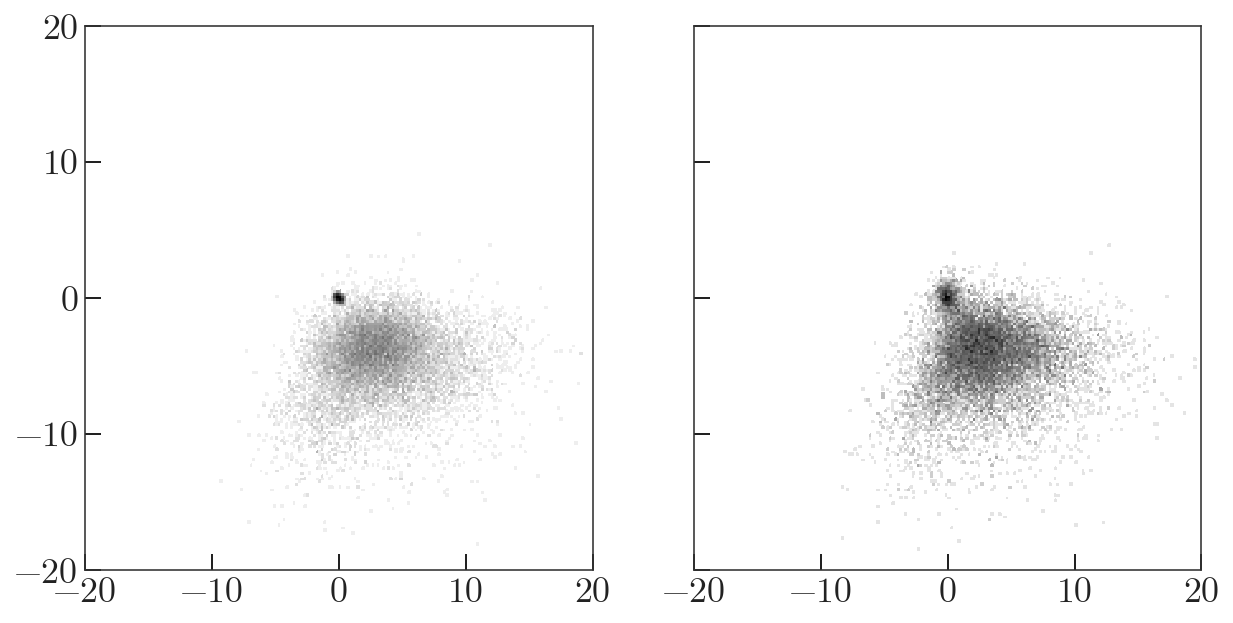

In [27]:
test = gmm.sample(size=X_bg.shape[0])
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]

H_test, xe, ye = np.histogram2d(test[:, 0], test[:, 1], bins=np.arange(-20, 20+1e-3, 0.2))
ax.pcolormesh(xe, ye, H_test.T, norm=mpl.colors.LogNorm(), cmap='Greys')

ax = axes[1]
H_test, xe, ye = np.histogram2d(X_bg[:, 0], X_bg[:, 1], bins=np.arange(-20, 20+1e-3, 0.2))
ax.pcolormesh(xe, ye, H_test.T, norm=mpl.colors.LogNorm(), cmap='Greys')

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

In [28]:
def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

def ln_prior(p):
    x, y, lns, lnf = p
    
    lp = 0
    
    if x < 0 or x > 10 or y < -10 or y > 0:
        return -np.inf
    
    lp += ln_normal(lns, -1, 5)
    lp += -lnf
    
    return lp

def ln_likelihood(p, gmm, X, Cov, return_blob=False):
    x, y, lns, lnf = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    mu = np.array([[x, y]])
    V = np.array([[[s, 0],
                   [0, s]]]) ** 2
    
    T = Cov + V
    logproba = log_multivariate_gaussian(X, mu, T)
    
    ll1 = logsumexp(gmm.logprob_a(X, Cov), axis=-1) + np.log(1-f)
    ll2 = logproba + np.log(f)
    
    if return_blob:
        return np.logaddexp(ll1, ll2).sum(), ll1, ll2
    else:
        return np.logaddexp(ll1, ll2).sum()

def ln_posterior(p, *args):
    lnp = ln_prior(p)
    if not np.isfinite(lnp):
        return -np.inf, -np.inf, -np.inf

    lnl, *blob = ln_likelihood(p, return_blob=True, *args)
    # lnl = ln_likelihood(p, *args)
    if not np.isfinite(lnl):
        return -np.inf, -np.inf, -np.inf

    return lnp + lnl, blob[0], blob[1]

In [29]:
from schwimmbad import MultiPool
import emcee
from tqdm import trange

In [31]:
filename = 'pm_membership_samples.pickle'
if not path.exists(filename):
    # p0 = (pmxy0[0], pmxy0[1], np.log(0.1), np.log(0.1))
    # p0 = [ 8.02471632, -3.9663445 , -2.27526062, -4.07480239]
    # res = minimize(lambda *args, **kwargs: -ln_likelihood(*args, **kwargs)[0],
    #                x0=p0, args=(gmm, X_jh[::8], Cov_jh[::8]), 
    #                method='L-BFGS-B')
    # print('done optimize', res)
    # pp = res.x
    pp = [ 8.02471632, -3.9663445 , -2.27526062, -4.07480239]
    
    dsamp = 4
    dtype = [("ll1", (float, X_jh[::dsamp].shape[0])), 
             ("ll2", (float, X_jh[::dsamp].shape[0]))]
    
    nwalkers = 32
    emcee_p0 = emcee.utils.sample_ball(pp, [1e-3]*len(pp), size=nwalkers)
    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, len(pp), ln_posterior,
                                        blobs_dtype=dtype,
                                        args=(gmm, X_jh[::dsamp], Cov_jh[::dsamp]),
                                        pool=pool, )

        pos, *_ = sampler.run_mcmc(emcee_p0, 128, progress=True)
    print('done burn-in')

    sampler.log_prob_fn = None
    with open(filename, 'wb') as f:
        pickle.dump(sampler, f)
    
else:
    with open(filename, 'rb') as f:
        sampler = pickle.load(f)

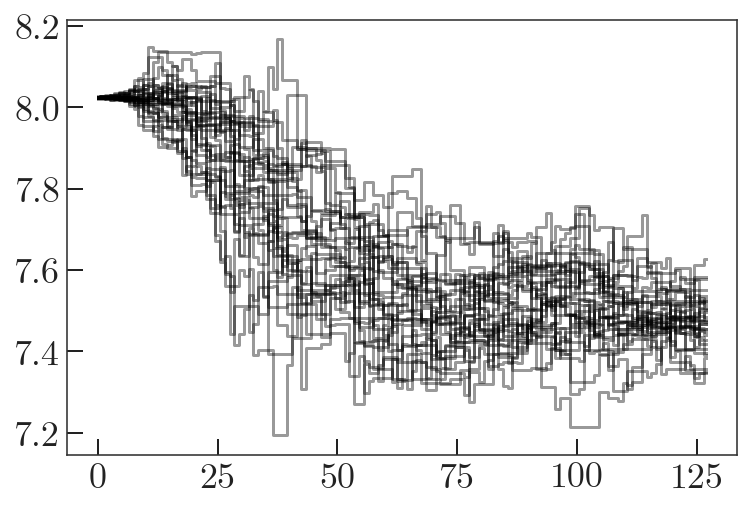

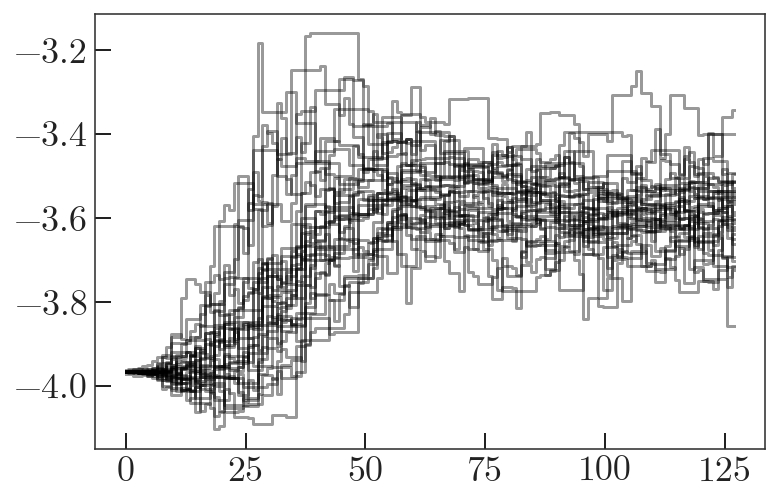

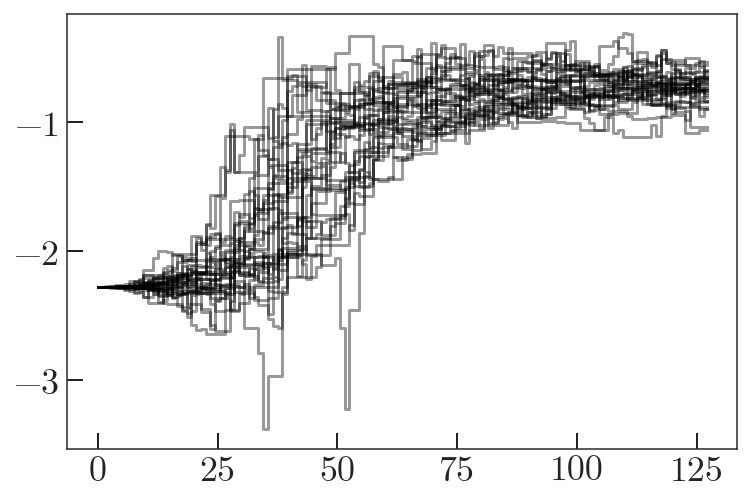

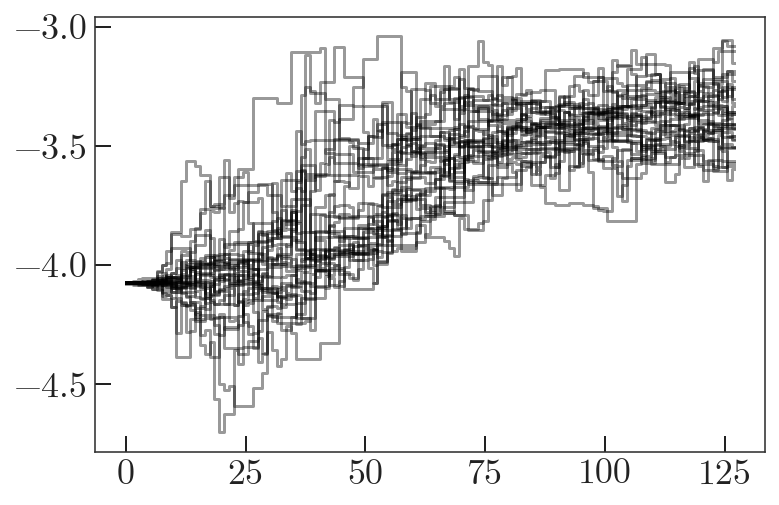

In [32]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, drawstyle='steps-mid', marker='', alpha=0.4, color='k')

In [33]:
flatchain = np.vstack(sampler.chain[:, -28:])
med_pp = np.median(flatchain, axis=0)

map_idx = np.ravel(sampler.lnprobability[-28:]).argmax()
map_pp = flatchain[map_idx]

In [34]:
cand_mask = jh_mask & (g.h_m < 14.)
mu_cand = mu[cand_mask]
V_cand = V[cand_mask]
mu_cand.shape

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(688, 2)

In [35]:
norm = 0.0
post_prob = np.zeros(cand_mask.sum())
for i in trange(flatchain.shape[0]):
    _, ll_bg, ll_fg = ln_likelihood(flatchain[i], gmm, mu_cand, V_cand, 
                                    return_blob=True)
    post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
    norm += 1
post_prob /= norm

100%|██████████| 896/896 [04:42<00:00,  3.17it/s]


In [36]:
(post_prob > 0.01).sum()

31

In [37]:
final_RGB_mask = ((post_prob > 0.01) & (mG[cand_mask] < 18*u.mag) & 
                  (mBPRP[cand_mask] > 0.78*u.mag) & (g.ph_qual[cand_mask] == 'AAA'))

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:461: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


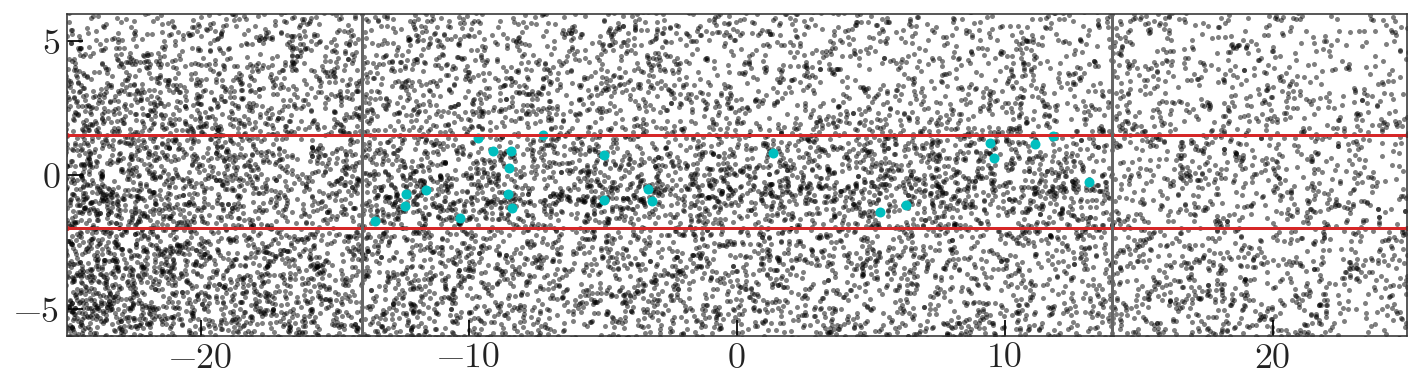

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bum_mask = pm_mask & cmd_box
ax.plot(phi1[bum_mask], phi2[bum_mask], 
        marker='.', ls='none', alpha=0.5, color='k')

ax.plot(phi1[cand_mask][final_RGB_mask], 
        phi2[cand_mask][final_RGB_mask], 
        marker='o', ls='none', alpha=1, color='c')

ax.axhline(-2., color='tab:red')
ax.axhline(1.5, color='tab:red')
ax.axvline(-14)
ax.axvline(14)

ax.set_xlim(-25, 25)
ax.set_ylim(-6, 6)
ax.set_aspect('equal')

In [39]:
tbl = g.data[cand_mask][final_RGB_mask]

In [41]:
tbl.write('../data/jhelum_candidates.csv')